In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 120)

In [2]:
df = pd.read_csv("../../data/processed_data/data_EDA.csv")
df['pickup_time'] = pd.to_datetime(df['pickup_time'], utc=True)

df.head()

,user_id,loyalty_status,age,city,avg_rating_given,churn_prob,trip_id,driver_id,fare,surge_multiplier,tip,payment_type,pickup_time,pickup_lat,pickup_lng,dropoff_lat,dropoff_lng,weather,pickup_time_year,pickup_time_month,pickup_time_month_year,pickup_time_day,pickup_time_day_num,pickup_hour,time_of_day,pickup_is_weekend,pickup_is_peak_hour,pickup_is_night,pickup_time_season,trip_duration_min,trip_distance_km,total_fare,total_fare_with_tip,tip_percentage,is_surge_trip,total_fare_bucket,bad_weather_flag,weather_surge_interaction,weather_demand_index
0,R00000,Bronze,34,Nairobi,5.0,0.142431,T001144,D03414,23.62,1.4,0.00,Card,2024-09-03 22:29:02+00:00,-1.115239,36.805339,-1.136842,36.793631,Rainy,2024,9,Sep 2024,Tuesday,3,22,Late Night,False,False,True,Autumn,26.0,2.732109,33.068,33.068,0.000000,True,very_high,1,1.4,0.199880
1,R00000,Bronze,34,Nairobi,5.0,0.142431,T022441,D04441,16.31,1.0,0.00,Card,2025-04-02 14:46:29+00:00,-1.350546,36.745210,-1.339873,36.770102,Sunny,2025,4,Apr 2025,Wednesday,2,14,Afternoon,False,False,False,Spring,6.0,3.010959,16.310,16.310,0.000000,False,high,0,0.0,0.600755
2,R00000,Bronze,34,Nairobi,5.0,0.142431,T024771,D00635,9.66,1.0,0.03,Card,2024-05-23 07:10:47+00:00,-1.316560,36.687127,-1.310676,36.680729,Sunny,2024,5,May 2024,Thursday,23,7,Morning,False,True,False,Spring,56.0,0.966453,9.660,9.690,0.003096,False,low,0,0.0,0.600755
3,R00000,Bronze,34,Nairobi,5.0,0.142431,T042553,D03102,11.02,1.1,0.55,Mobile Money,2025-01-02 13:42:13+00:00,-1.726473,37.301560,-1.713882,37.311035,Sunny,2025,1,Jan 2025,Thursday,2,13,Afternoon,False,False,False,Winter,36.0,1.751916,12.122,12.672,0.043403,True,medium,0,0.0,0.600755
4,R00000,Bronze,34,Nairobi,5.0,0.142431,T055259,D03417,20.83,1.0,0.91,Card,2025-01-07 11:56:49+00:00,-1.483414,36.974683,-1.474478,36.932673,Sunny,2025,1,Jan 2025,Tuesday,7,11,Morning,False,False,False,Winter,20.0,4.774206,20.830,21.740,0.041858,False,high,0,0.0,0.600755


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   user_id                    200000 non-null  object             
 1   loyalty_status             200000 non-null  object             
 2   age                        200000 non-null  int64              
 3   city                       200000 non-null  object             
 4   avg_rating_given           200000 non-null  float64            
 5   churn_prob                 200000 non-null  float64            
 6   trip_id                    200000 non-null  object             
 7   driver_id                  200000 non-null  object             
 8   fare                       200000 non-null  float64            
 9   surge_multiplier           200000 non-null  float64            
 10  tip                        200000 non-null  float64     

### Aggregate to User-Level Dataset for Behavioural Features

In [4]:
snapshot_date = df['pickup_time'].max() + pd.Timedelta(days=1)


user_df = df.groupby('user_id').agg(
    recency=('pickup_time', lambda x: (snapshot_date - x.max()).days),
    total_trips=('trip_id', 'count'),
    total_spend=('fare', 'sum'),
    avg_spend=('fare', 'mean'),
    avg_surge=('surge_multiplier', 'mean'),
    total_tip=('tip', 'sum'),
    avg_tip=('tip', 'mean'),
    avg_rating_given=('avg_rating_given', 'mean'),
    loyalty_status=('loyalty_status', 'first'),
    city=('city', 'first'),
    first_trip=('pickup_time', 'min'),
    last_trip=('pickup_time', 'max'),
    avg_distance=('trip_distance_km', 'mean'),
    avg_duration=('trip_duration_min', 'mean')
).reset_index()

user_df['active_days'] = (user_df['last_trip'] - user_df['first_trip']).dt.days
user_df.drop(columns=['first_trip', 'last_trip',], inplace=True)

user_df.info()
print('\n')
user_df.head(5)

user_df.to_csv('../../data/processed_data/user_agg_df.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  object 
 1   recency           10000 non-null  int64  
 2   total_trips       10000 non-null  int64  
 3   total_spend       10000 non-null  float64
 4   avg_spend         10000 non-null  float64
 5   avg_surge         10000 non-null  float64
 6   total_tip         10000 non-null  float64
 7   avg_tip           10000 non-null  float64
 8   avg_rating_given  10000 non-null  float64
 9   loyalty_status    10000 non-null  object 
 10  city              10000 non-null  object 
 11  avg_distance      10000 non-null  float64
 12  avg_duration      10000 non-null  float64
 13  active_days       10000 non-null  int64  
dtypes: float64(8), int64(3), object(3)
memory usage: 1.1+ MB




In [5]:
user_df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,10000,10000,R09983,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recency,10000.0,NaN,NaN,NaN,19.1699,18.363659,1.0,6.0,13.0,26.0,175.0
total_trips,10000.0,NaN,NaN,NaN,20.0,4.49838,6.0,17.0,20.0,23.0,42.0
total_spend,10000.0,NaN,NaN,NaN,308.025691,74.760409,78.87,255.26,304.725,356.75,663.91
avg_spend,10000.0,NaN,NaN,NaN,15.398338,1.405701,11.030833,14.410978,15.30475,16.282675,22.142222
avg_surge,10000.0,NaN,NaN,NaN,1.141572,0.058819,1.0,1.1,1.136364,1.177778,1.4125
total_tip,10000.0,NaN,NaN,NaN,9.391318,6.108403,0.0,4.9,8.19,12.59,46.29
avg_tip,10000.0,NaN,NaN,NaN,0.469579,0.292674,0.0,0.255714,0.412083,0.621446,2.708462
avg_rating_given,10000.0,NaN,NaN,NaN,4.46151,0.429162,2.6,4.2,4.5,4.8,5.0
loyalty_status,10000,4,Bronze,6057,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Quick EDA

In [6]:
num_cols = user_df.select_dtypes(include='number')

In [7]:
num_cols.describe().transpose()[['mean', '50%', 'min', 'max']].round(2)

,mean,50%,min,max
recency,19.17,13.00,1.00,175.00
total_trips,20.00,20.00,6.00,42.00
total_spend,308.03,304.73,78.87,663.91
avg_spend,15.40,15.30,11.03,22.14
avg_surge,1.14,1.14,1.00,1.41
total_tip,9.39,8.19,0.00,46.29
avg_tip,0.47,0.41,0.00,2.71
avg_rating_given,4.46,4.50,2.60,5.00
avg_distance,4.15,4.14,2.63,5.65
avg_duration,31.95,32.00,16.58,46.83


##### Insights after aggregating data to user level

Overview: There are no extreme values for the minimum values and maximum values for each column. This indicates the presence of high value cusotmers such as High frequency riders, High income users, Long distance riders, etc.

Shape of the distribution:
The data consists of a mixture of relatively uniform distributions and well as skewed distributions. As the mean is equal to the median in some columns whereas it is not in other columns. This would be further explored by visualizing the distribtions. 

#### Exploring the shape of the distribution

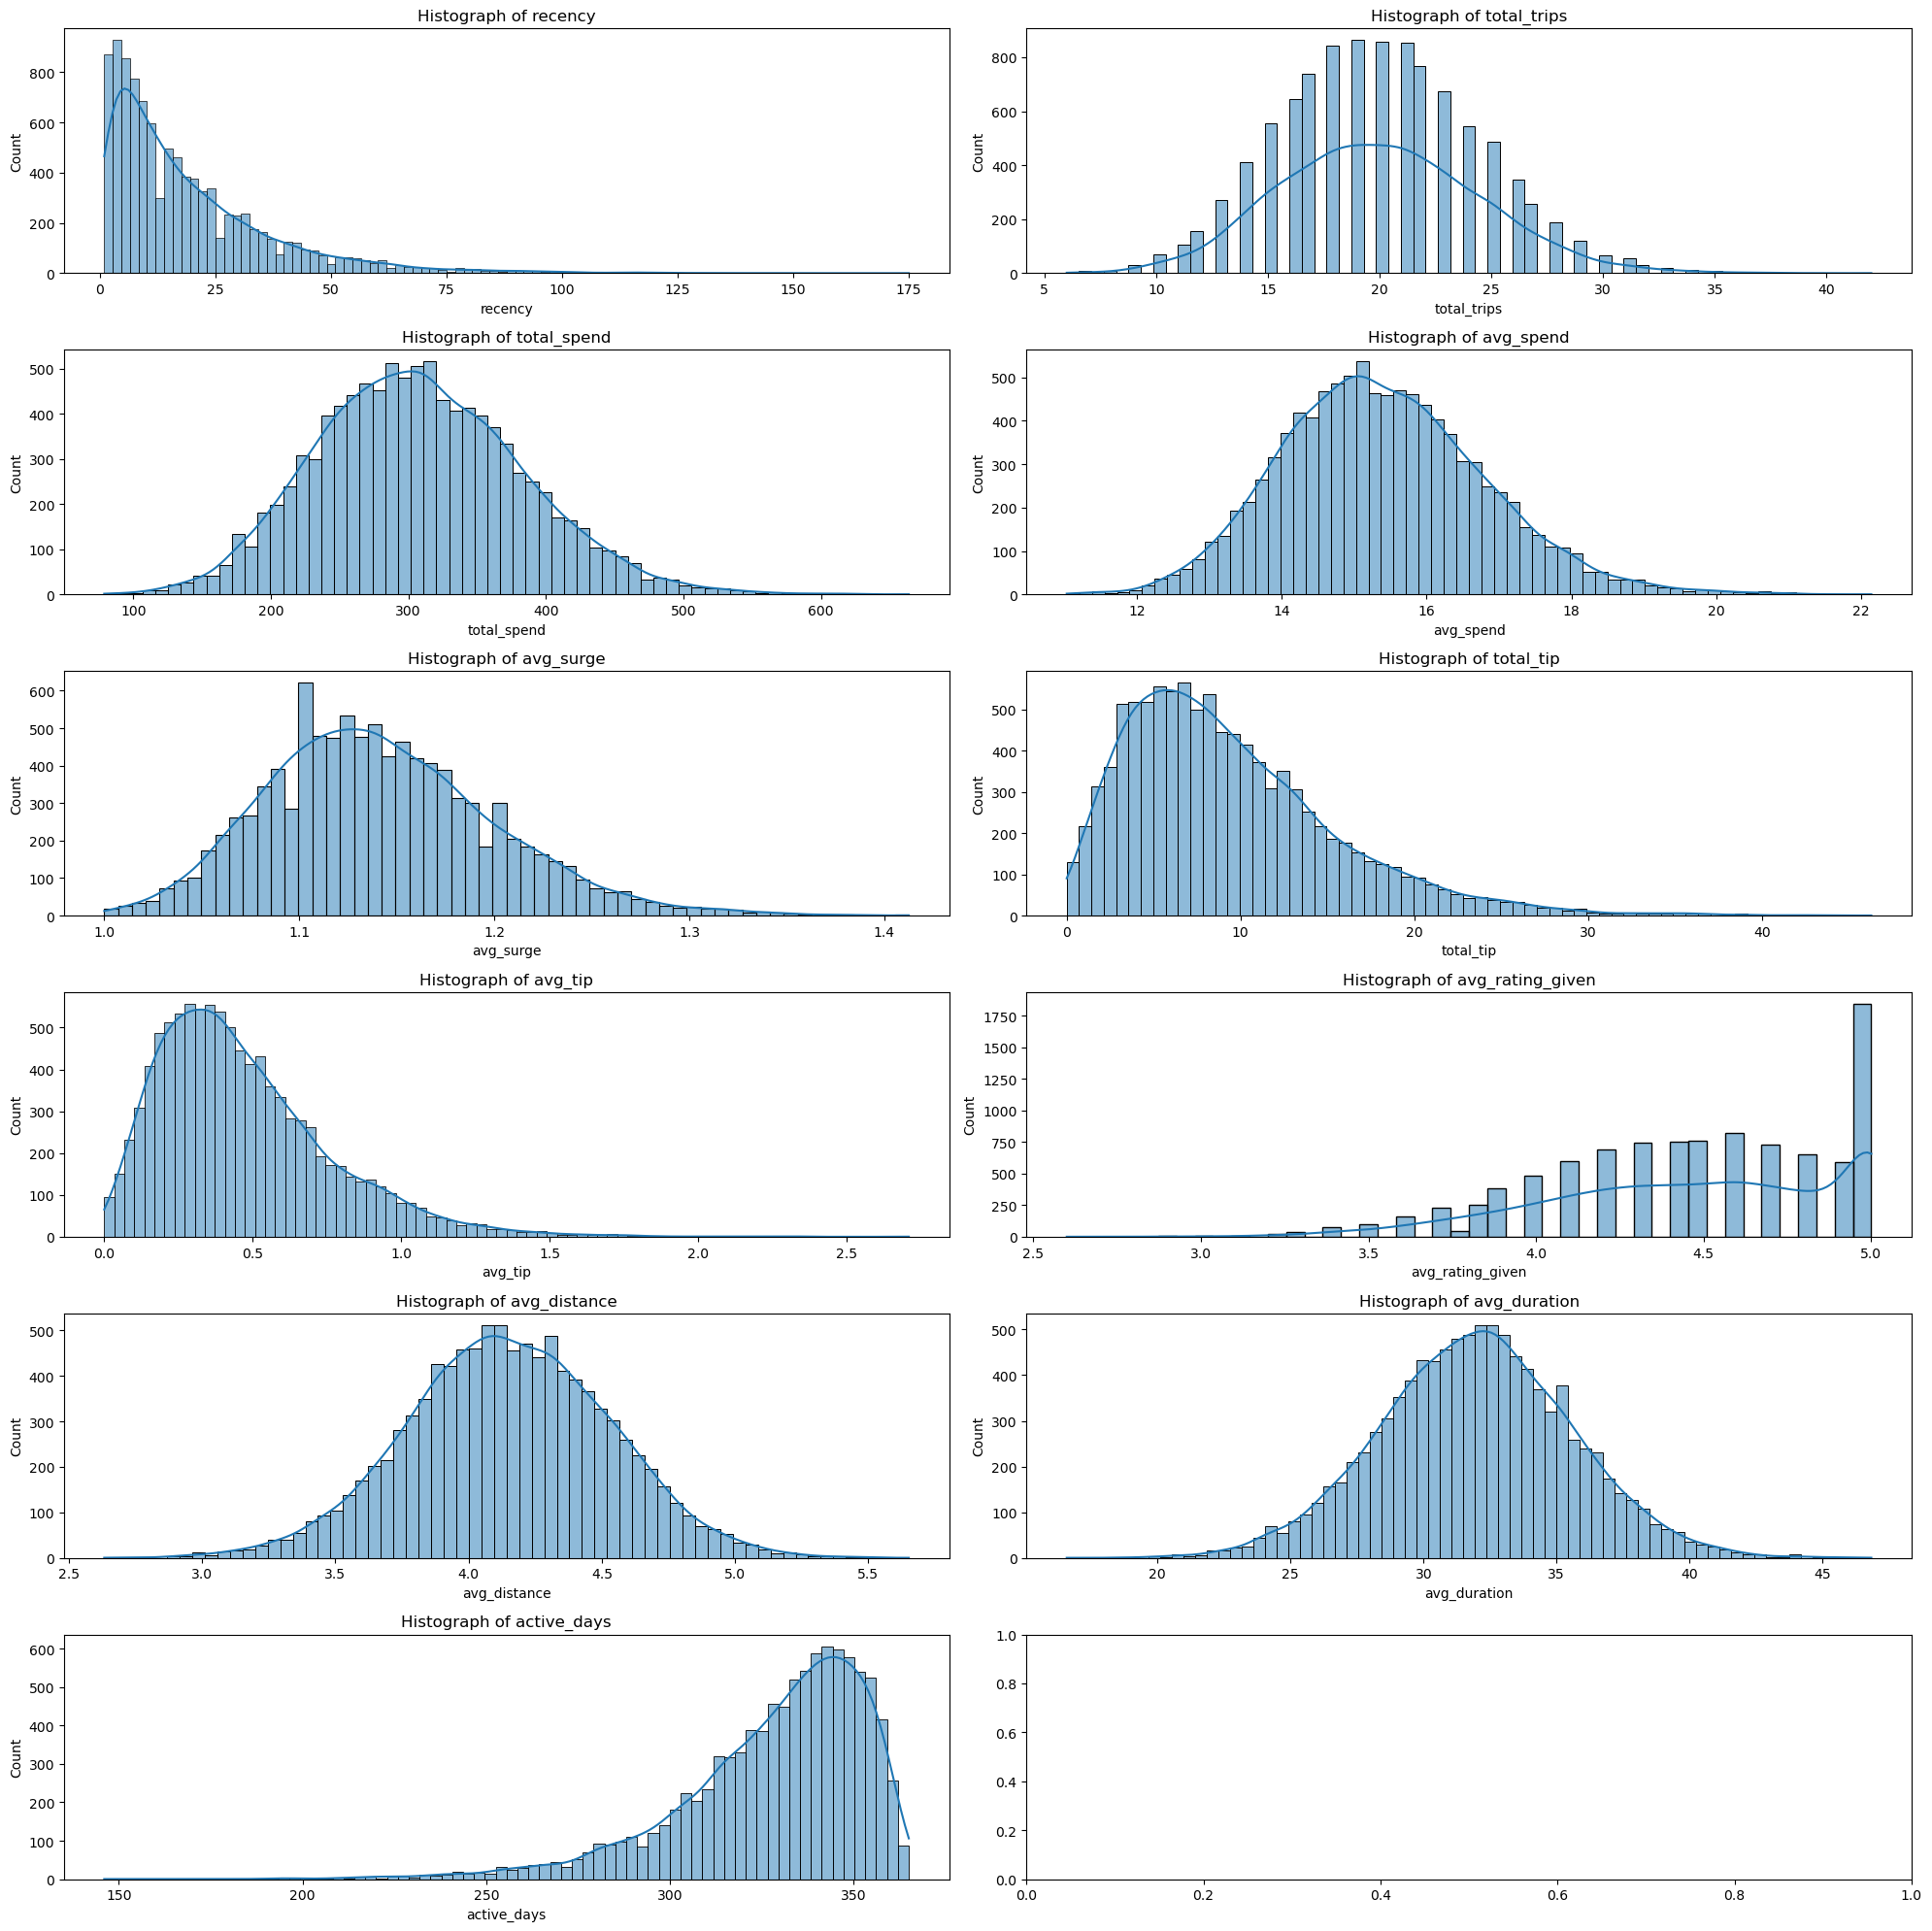

In [8]:
num_cols = user_df.select_dtypes(include='number')

fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20,20))
ax = ax.flatten()
for idx, column in enumerate(num_cols):
        sns.histplot(user_df[column], ax=ax[idx], kde=True)
        ax[idx].set_title(f"Histograph of {column}")
plt.tight_layout()
plt.show();

The shape of the distributions can be described as:
- Skewed Ditributions: Recency, Avg_tip, Avg_rating_given, Active_days. All skewed distributions have long tails indicating the presence of extreme values (Outliers). 
- Uniform Distributions: Total_trips, Total_spend, Avg_fare, Avg_surge, avg_distance.

#### Exploration of Outliers

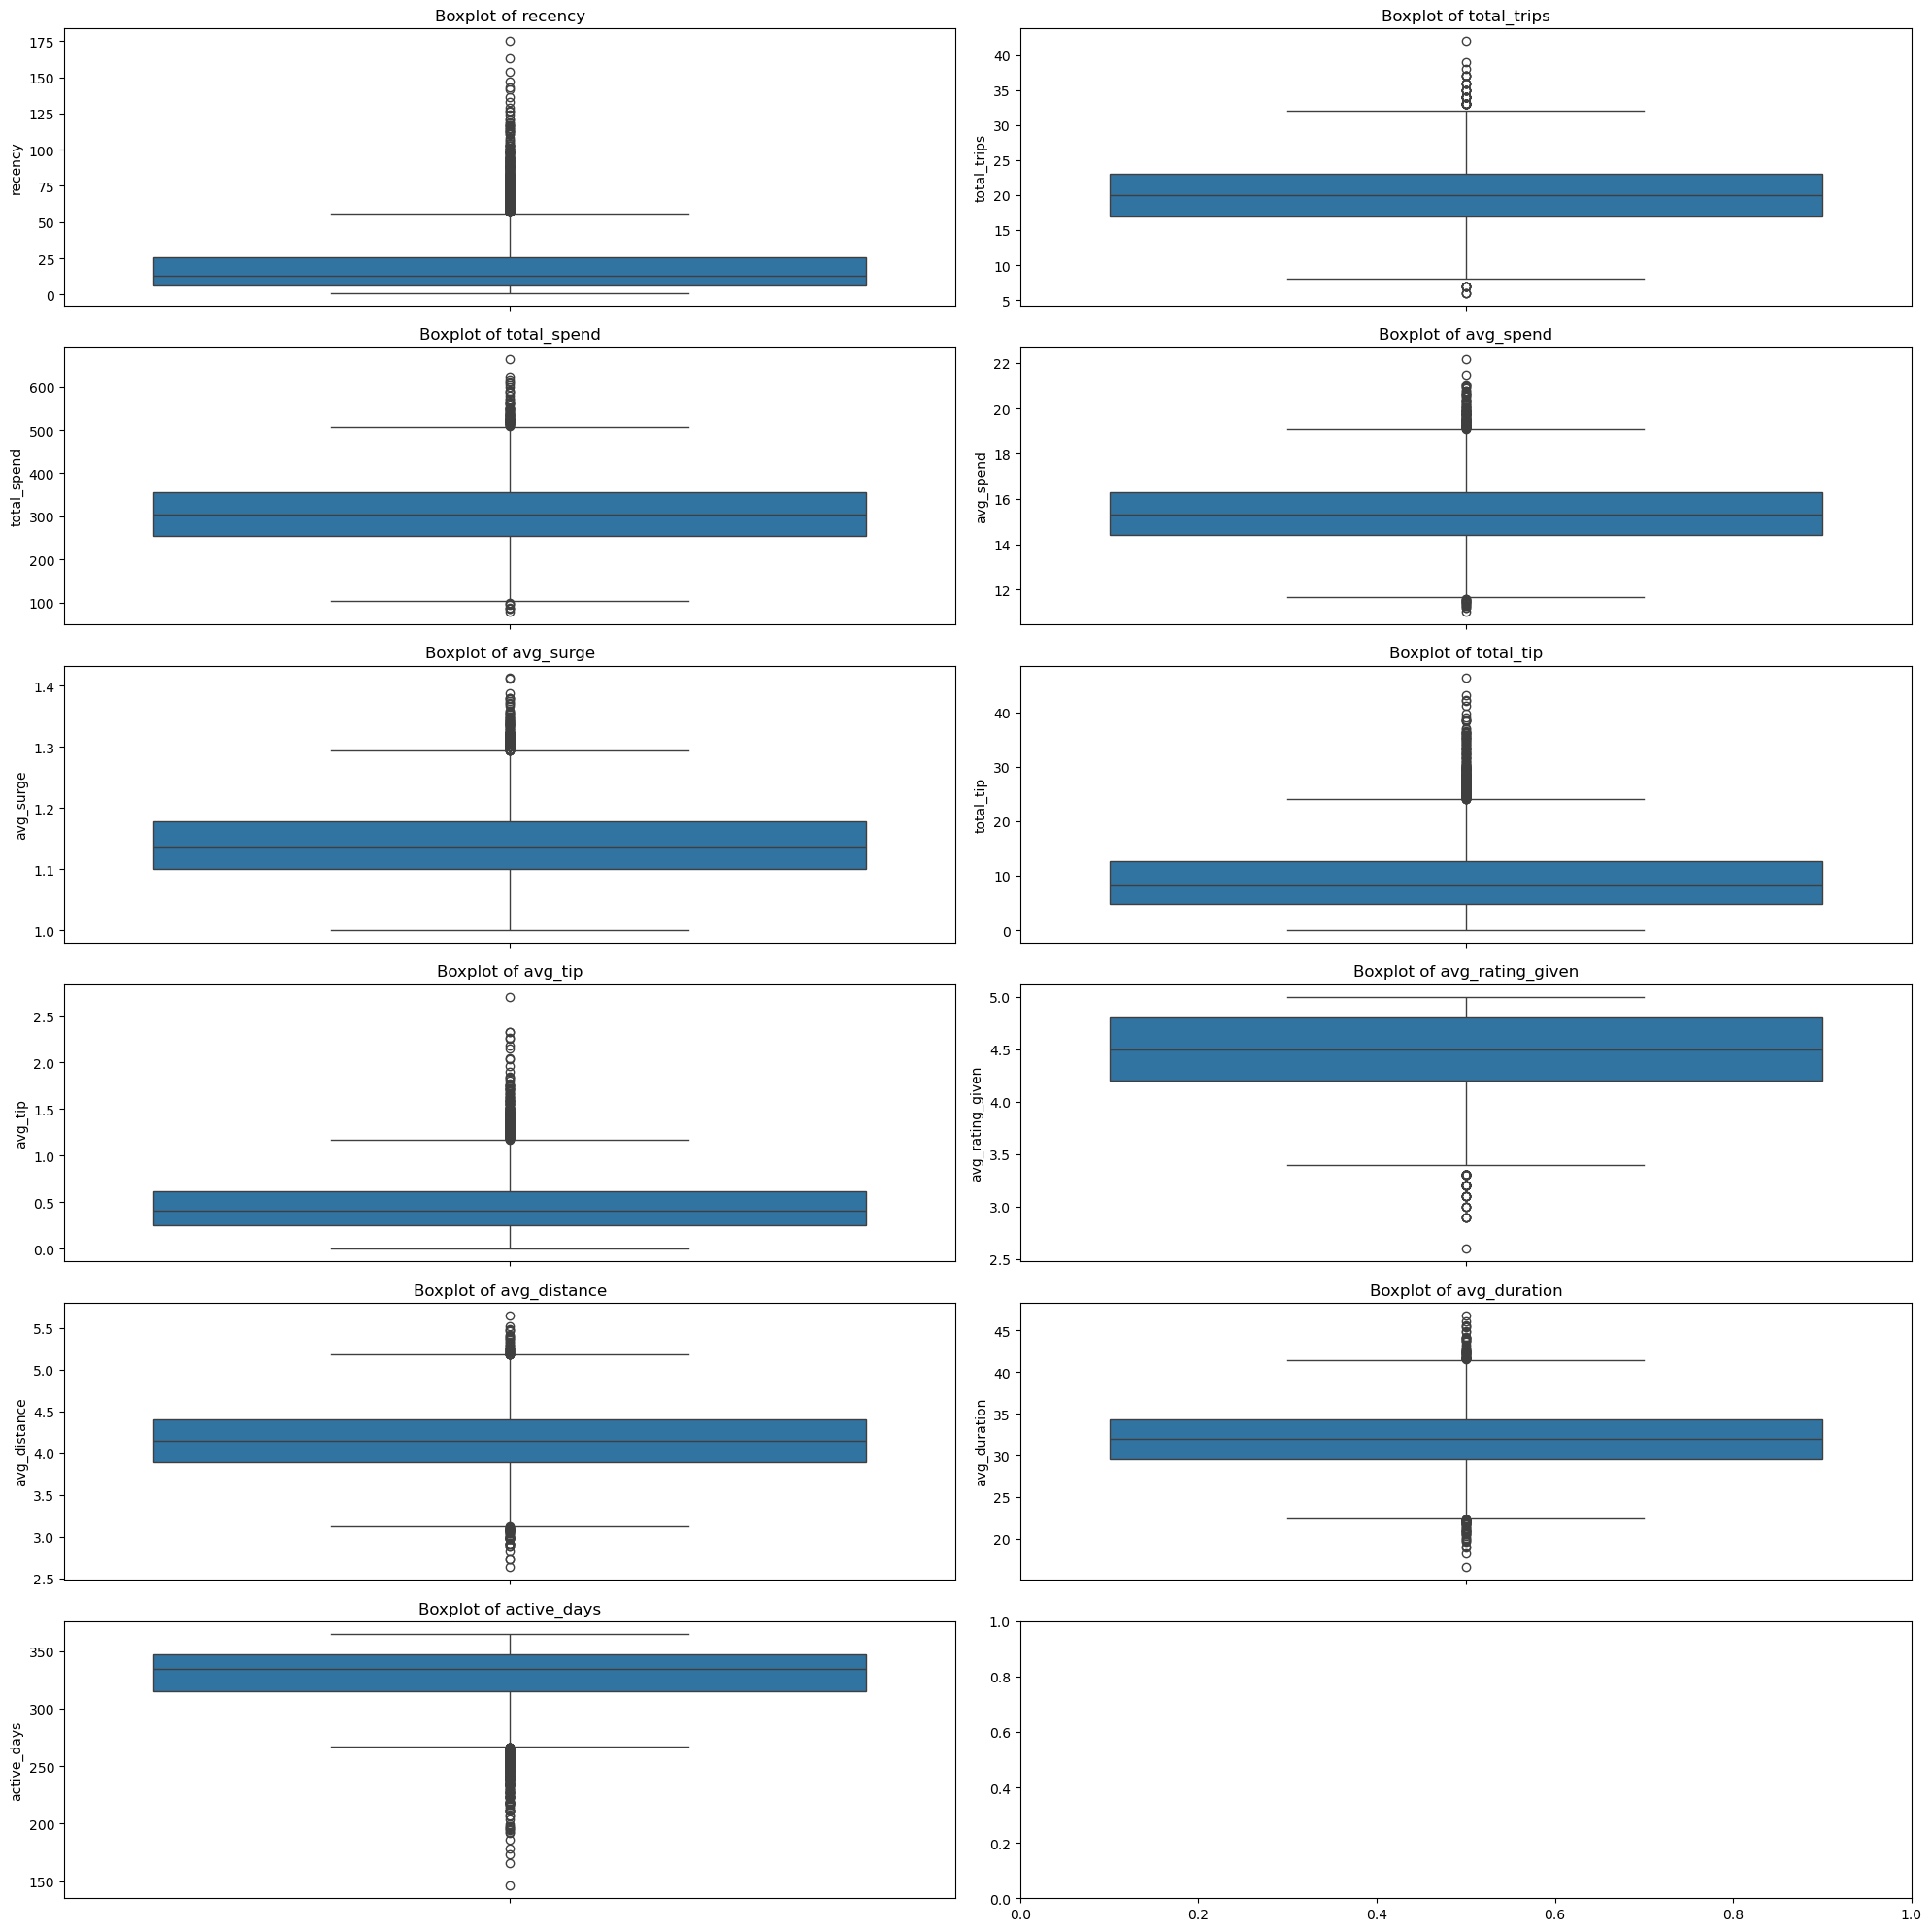

In [9]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20,20))
ax = ax.flatten()
for idx, column in enumerate(num_cols):
    sns.boxplot(user_df[column], ax=ax[idx])
    ax[idx].set_title(f"Boxplot of {column}")
plt.tight_layout()
plt.show();

In [10]:
# Swan plots

# fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
# ax = ax.flatten()

# for idx, column in enumerate(num_cols):
#     sns.violinplot(x=user_df[column], ax=ax[idx])
#     ax[idx].set_title(f"Boxplot of {column}")
# plt.tight_layout()
# plt.show();

### Correlation between variables

In [11]:
num_cols_corr = num_cols.corr().round(2)
num_cols_corr

,recency,total_trips,total_spend,avg_spend,avg_surge,total_tip,avg_tip,avg_rating_given,avg_distance,avg_duration,active_days
recency,1.00,-0.21,-0.20,0.01,0.02,-0.08,-0.01,0.00,0.01,-0.01,-0.71
total_trips,-0.21,1.00,0.93,0.01,-0.01,0.34,-0.00,-0.00,0.01,0.01,0.31
total_spend,-0.20,0.93,1.00,0.37,0.19,0.35,0.03,-0.00,0.01,0.00,0.28
avg_spend,0.01,0.01,0.37,1.00,0.55,0.08,0.08,-0.01,0.01,-0.00,-0.00
avg_surge,0.02,-0.01,0.19,0.55,1.00,-0.01,-0.02,0.01,0.02,-0.01,-0.01
total_tip,-0.08,0.34,0.35,0.08,-0.01,1.00,0.91,-0.00,0.01,-0.00,0.12
avg_tip,-0.01,-0.00,0.03,0.08,-0.02,0.91,1.00,-0.01,0.00,-0.00,0.01
avg_rating_given,0.00,-0.00,-0.00,-0.01,0.01,-0.00,-0.01,1.00,0.00,-0.00,0.02
avg_distance,0.01,0.01,0.01,0.01,0.02,0.01,0.00,0.00,1.00,0.01,-0.02
avg_duration,-0.01,0.01,0.00,-0.00,-0.01,-0.00,-0.00,-0.00,0.01,1.00,0.01


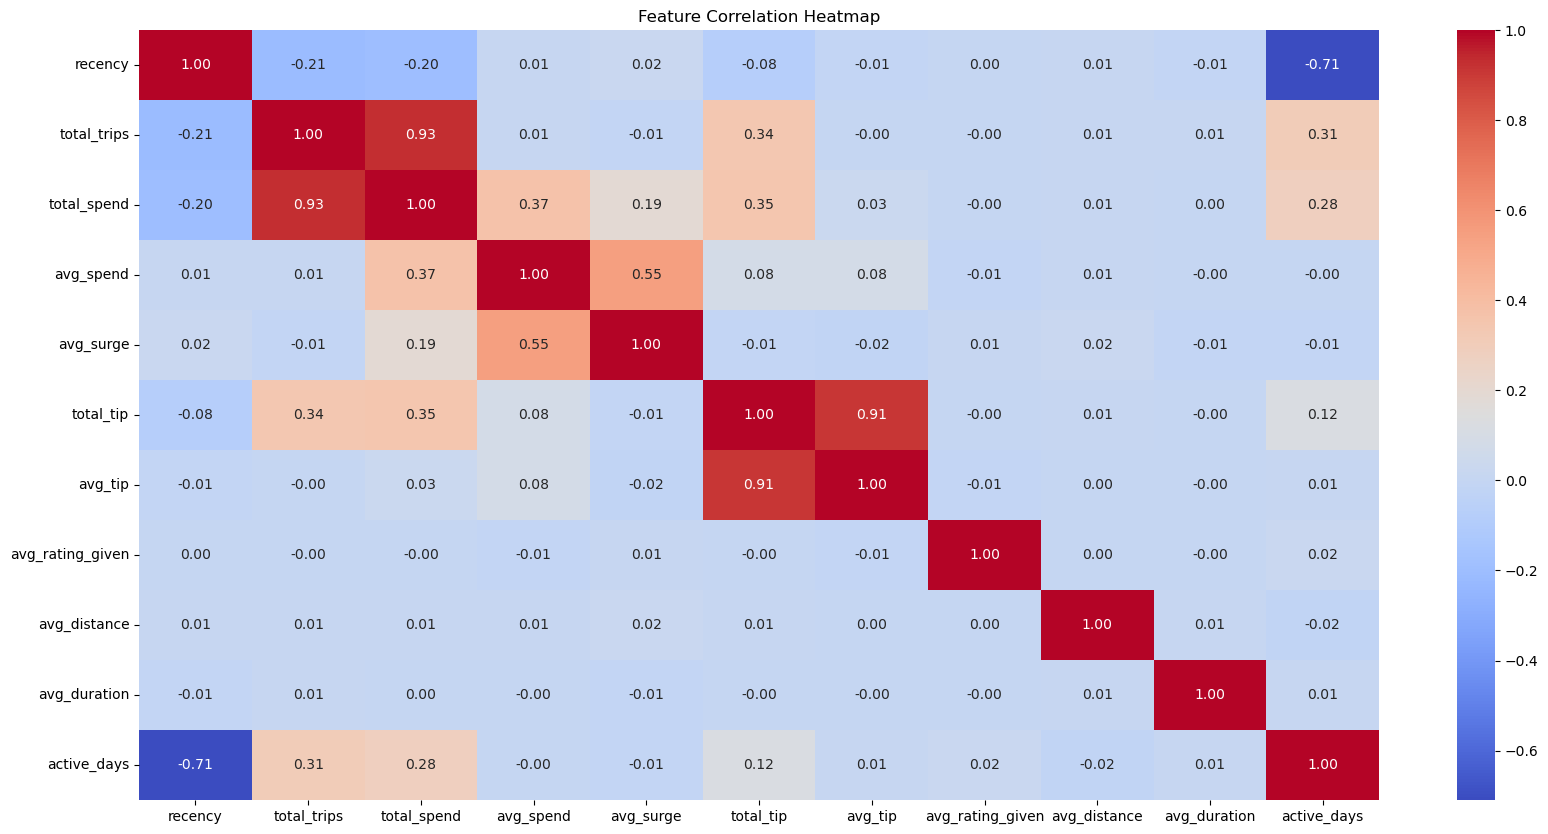

In [12]:
plt.figure(figsize=(20,10))
sns.heatmap(num_cols_corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()